In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

# Data

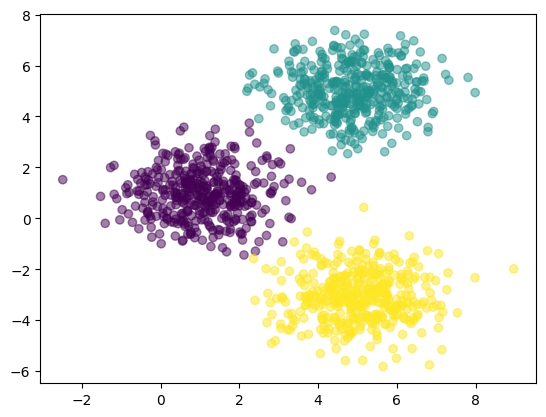

In [ ]:
n_per_clust = 400
blur = 1

A = [1,1]
B = [5,5]
C = [5,-3]

a = [A[0] + np.random.randn(n_per_clust) * blur, A[1] + np.random.randn(n_per_clust) * blur]
b = [B[0] + np.random.randn(n_per_clust) * blur, B[1] + np.random.randn(n_per_clust) * blur]
c = [C[0] + np.random.randn(n_per_clust) * blur, C[1] + np.random.randn(n_per_clust) * blur]

labels_np = np.hstack((
    np.zeros(n_per_clust),
    np.ones(n_per_clust),
    1 + np.ones(n_per_clust)
))

data_np = np.hstack((
    a,b,c
)).T

labels = torch.tensor(labels_np, dtype = torch.long)
data = torch.tensor(data_np, dtype = torch.float)

plt.scatter(data[:,0], data[:,1], c = labels, alpha =.5)

plt.show()

# Split

In [ ]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size = .2)

train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

train_dataloader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = test_data.shape[0])

# Model Arch

In [ ]:
class ModelArch(nn.Module):
  def __init__(self):
    super().__init__()

    self.input = nn.Linear(2, 16)
    self.f1 = nn.Linear(16,32)
    self.f2 = nn.Linear(32, 32)
    self.output = nn.Linear(32, 3)

  def forward(self, x):
    x = self.input(x)
    x = F.relu(x)
    x = self.f1(x)
    x = F.relu(x)
    x = self.f2(x)
    x = F.relu(x)
    x = self.output(x)

    return x

# Model Setup

In [ ]:
def ModelSetup(optimizer, lr):
  ann = ModelArch()
  loss_fn = nn.CrossEntropyLoss()
  optimizer = optimizer(ann.parameters(), lr = lr)
  return ann, loss_fn, optimizer

In [ ]:
ann, loss_fn, optimizer = ModelSetup(torch.optim.SGD, lr = 1e-3)
temp_data = torch.randn(10, 2)
temp_y_hat = ann(temp_data)
temp_y_hat

tensor([[ 0.0488, -0.0193, -0.0476],
        [ 0.0500, -0.0344, -0.0672],
        [ 0.0479, -0.0198, -0.0517],
        [ 0.0502, -0.0250, -0.0575],
        [ 0.0518, -0.0594, -0.0209],
        [ 0.0550, -0.0452, -0.0589],
        [ 0.0446, -0.0379, -0.0325],
        [ 0.0510, -0.0303, -0.0553],
        [ 0.0530, -0.1025, -0.0447],
        [ 0.0415, -0.0339, -0.0636]], grad_fn=<AddmmBackward0>)

# Model Train

In [33]:
def ModelTrain(epochs, optimizer, lr):
  ann, loss_fn, optimizer = ModelSetup(optimizer, lr)

  train_losses = torch.zeros(epochs)
  test_losses = torch.zeros(epochs)
  train_accs = torch.zeros(epochs)
  test_accs = torch.zeros(epochs)

  for epoch in range(epochs):
    ann.train()

    batch_losses = torch.zeros(len(train_dataloader))
    batch_accs = torch.zeros(len(train_dataloader))

    for batch, (X_train, y_train) in enumerate(train_dataloader):

      batch_y_hat = ann(X_train)

      batch_loss = loss_fn(batch_y_hat, y_train)
      batch_losses[batch] = batch_loss

      batch_acc = 100 * torch.mean(
          (torch.argmax(batch_y_hat, axis = 1) == y_train).float()
      )
      batch_accs[batch] = batch_acc

      optimizer.zero_grad()
      batch_loss.backward()
      optimizer.step()

    train_loss = torch.mean(batch_losses)
    train_losses[epoch] = train_loss
    train_acc = torch.mean(batch_accs)
    train_accs[epoch] = train_acc

    ann.eval()
    with torch.no_grad():
      X_test, y_test = next(iter(test_dataloader))
      test_y_hat = ann(X_test)

      test_loss = loss_fn(test_y_hat, y_test)
      test_losses[epoch] = test_loss

      test_acc = 100 * torch.mean(
          (torch.argmax(test_y_hat, axis = 1) == y_test).float()
      )
      test_accs[epoch] = test_acc

    if epoch%10 == 0:
      print(f'Train Loss: {train_loss:.2f}, Train Acc: {train_acc:.2f}, Test Loss: {test_loss:.2f}, Test Acc: {test_acc:.2f}')

  return train_losses, train_accs, test_losses, test_accs

In [34]:
train_losses, train_accs, test_losses, test_accs = ModelTrain(epochs = 100, optimizer = torch.optim.SGD, lr = 1e-3)

Train Loss: 1.14, Train Acc: 11.67, Test Loss: 1.14, Test Acc: 9.58
Train Loss: 1.04, Train Acc: 46.77, Test Loss: 1.03, Test Acc: 50.42
Train Loss: 0.96, Train Acc: 57.50, Test Loss: 0.95, Test Acc: 60.42
Train Loss: 0.87, Train Acc: 63.65, Test Loss: 0.87, Test Acc: 66.25
Train Loss: 0.79, Train Acc: 65.73, Test Loss: 0.78, Test Acc: 68.75
Train Loss: 0.71, Train Acc: 66.67, Test Loss: 0.70, Test Acc: 69.58
Train Loss: 0.64, Train Acc: 69.17, Test Loss: 0.62, Test Acc: 71.25
Train Loss: 0.58, Train Acc: 70.73, Test Loss: 0.56, Test Acc: 72.08
Train Loss: 0.53, Train Acc: 71.67, Test Loss: 0.51, Test Acc: 73.75
Train Loss: 0.50, Train Acc: 74.38, Test Loss: 0.47, Test Acc: 75.42


# Plot Single Run

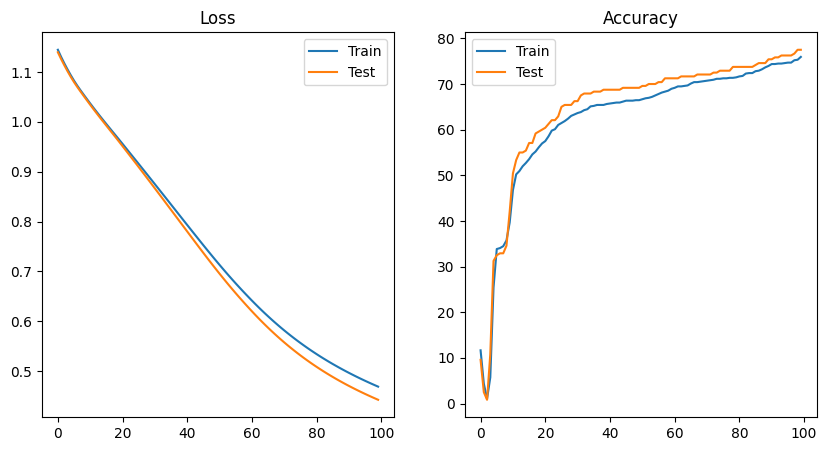

In [35]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))

ax[0].plot(train_losses.detach())
ax[0].plot(test_losses.detach())
ax[0].set_title('Loss')
ax[0].legend(['Train', 'Test'])

ax[1].plot(train_accs.detach())
ax[1].plot(test_accs.detach())
ax[1].set_title('Accuracy')
ax[1].legend(['Train', 'Test'])
plt.show()

# Experiment

In [96]:
epochs = 50
optimizers = {
    "SGD": torch.optim.SGD,
    "Adam": torch.optim.Adam,
    "RMSprop": torch.optim.RMSprop,
}
# we're going to use 20 logartihmically spaced learning rates
lrs = np.logspace(np.log10(.0001), np.log10(.1), 20)
# results = torch.zeros(1, len(optimizers), len(lrs), 1)
results = torch.zeros(len(optimizers), len(lrs))

for optimizer_idx, optimizer_name in enumerate(optimizers):
  for lr_idx, lr_value in enumerate(lrs):
    print(f'\n\n\nPROCESSING OPTIMIZER: {optimizer_name} Learning Rate: {lr_value}')

    train_losses, train_accs, test_losses, test_accs = ModelTrain(epochs = epochs, optimizer = optimizers[optimizer_name], lr = lr_value)

    last_10_avg_test_acc = torch.mean(test_accs.detach()[-10:])
    results[optimizer_idx, lr_idx] = last_10_avg_test_acc




PROCESSING OPTIMIZER: SGD Learning Rate: 0.0001
Train Loss: 1.16, Train Acc: 0.62, Test Loss: 1.15, Test Acc: 0.00
Train Loss: 1.14, Train Acc: 0.62, Test Loss: 1.14, Test Acc: 0.00
Train Loss: 1.13, Train Acc: 0.62, Test Loss: 1.13, Test Acc: 0.42
Train Loss: 1.11, Train Acc: 1.15, Test Loss: 1.11, Test Acc: 0.83
Train Loss: 1.10, Train Acc: 2.71, Test Loss: 1.10, Test Acc: 2.92



PROCESSING OPTIMIZER: SGD Learning Rate: 0.0001438449888287663
Train Loss: 1.08, Train Acc: 0.31, Test Loss: 1.08, Test Acc: 0.83
Train Loss: 1.07, Train Acc: 14.69, Test Loss: 1.06, Test Acc: 21.25
Train Loss: 1.06, Train Acc: 32.50, Test Loss: 1.05, Test Acc: 36.25
Train Loss: 1.05, Train Acc: 32.50, Test Loss: 1.04, Test Acc: 36.67
Train Loss: 1.04, Train Acc: 32.50, Test Loss: 1.02, Test Acc: 36.67



PROCESSING OPTIMIZER: SGD Learning Rate: 0.00020691380811147902
Train Loss: 1.08, Train Acc: 32.50, Test Loss: 1.08, Test Acc: 36.67
Train Loss: 1.08, Train Acc: 32.50, Test Loss: 1.07, Test Acc: 36.67


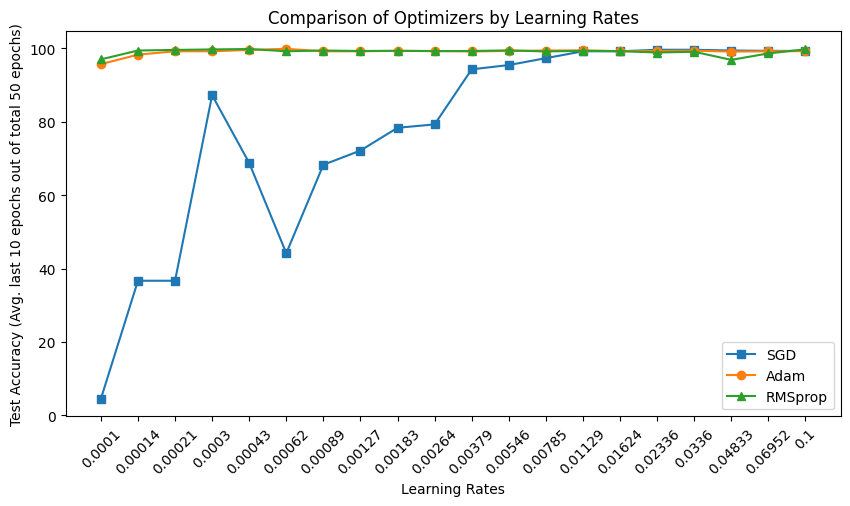

In [97]:
fig = plt.figure(figsize = (10, 5))
plt.plot(results[0], '-s',label = 'SGD')
plt.plot(results[1], '-o', label = 'Adam')
plt.plot(results[2], '-^',label = 'RMSprop')
plt.ylabel('Test Accuracy (Avg. last 10 epochs out of total 50 epochs)')
plt.legend(optimizers.keys())
plt.xlabel('Learning Rates')
plt.xticks(range(len(lrs)), [str(np.round(lr,5)) for lr in lrs], rotation = 45)
plt.title('Comparison of Optimizers by Learning Rates')
plt.show()

We can see that learning rate has huge impact over SGD, however Adam and RMSprop are resilient from learning rate fluctuations. That makes Adam and RMSprop dominant optimizers over SGD.